In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

In [2]:
import numpy as np
import nibabel as nib

import scm.scm as scm
import dipy.reconst.sfm as sfm
import dipy.core.gradients as grad
import dipy.core.optimize as opt
import dipy.data as dpd
import dipy.viz.projections as proj


In [3]:
hardi_img, gtab, labels_img = dpd.read_stanford_labels()
data = hardi_img.get_data()
#data = data[40:50, 40:50, 40:50]
labels = labels_img.get_data()
mask = (labels == 1) | (labels == 2)
#mask = np.zeros(mask.shape, dtype=bool)
#mask = np.zeros(data.shape[:-1], dtype=bool)
#mask[4:6, 4:6, 4:6] = True

Dataset is already in place. If you want to fetch it again, please first remove the folder /Users/arokem/.dipy/stanford_hardi 
All files already in /Users/arokem/.dipy/stanford_hardi.


In [4]:
n_split = 75

data_train = np.concatenate([data[..., :5], data[..., 10:85]], -1)
data_test = np.concatenate([data[..., 5:10], data[..., 85:]], -1)

gtab_train = grad.gradient_table_from_bvals_bvecs(np.concatenate([gtab.bvals[:5], gtab.bvals[10:85]]), 
                                                  np.concatenate([gtab.bvecs[:5], gtab.bvecs[10:85]]))

gtab_test = grad.gradient_table_from_bvals_bvecs(np.concatenate([gtab.bvals[5:10], gtab.bvals[85:]]), 
                                                 np.concatenate([gtab.bvecs[5:10], gtab.bvecs[85:]]))

In [5]:
scmodel = scm.SpatContModel(gtab_train)
scfit = scmodel.fit(data_train, mask)

/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:490: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [6]:
sfmodel = sfm.SparseFascicleModel(gtab_train)
sffit = sfmodel.fit(data_train, mask)

In [7]:
scp = scfit.predict(gtab=gtab_test)
sfp = sffit.predict(gtab=gtab_test)

In [8]:
idx = (50, 50, 50)

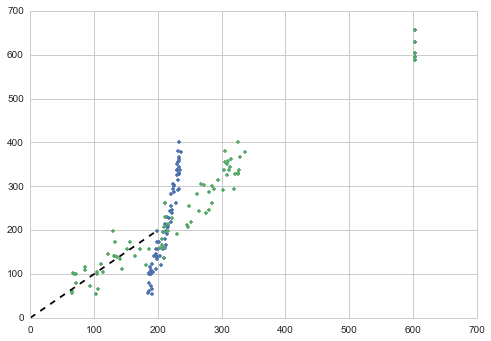

In [9]:
plt.plot(scp[idx], data_test[idx], '.')
plt.plot(sfp[idx], data_test[idx], '.')
plt.plot([0, 200], [0, 200], 'k--')

In [10]:
np.sqrt(np.mean((scp[idx] - data_test[idx])**2)), np.sqrt(np.mean((sfp[idx] - data_test[idx])**2))

(78.684869277101413, 31.986277953604485)

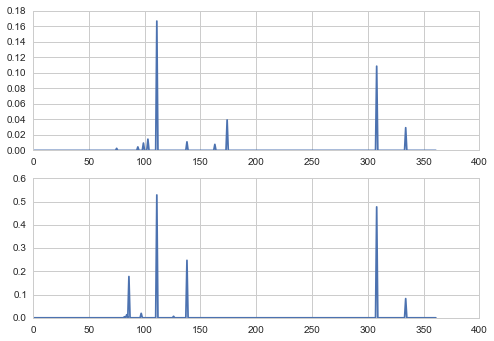

In [11]:
fig, ax = plt.subplots(2)
ax[1].plot(sffit.beta[idx])
ax[0].plot(scfit.beta[idx])


In [12]:
sc_odf = scfit.odf(scmodel.sphere)
sf_odf = sffit.odf(sfmodel.sphere)

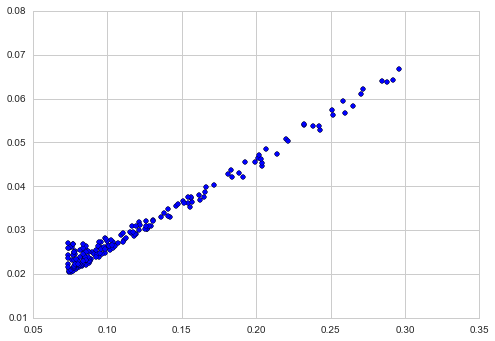

In [13]:
plt.scatter(sf_odf[idx], sc_odf[idx])

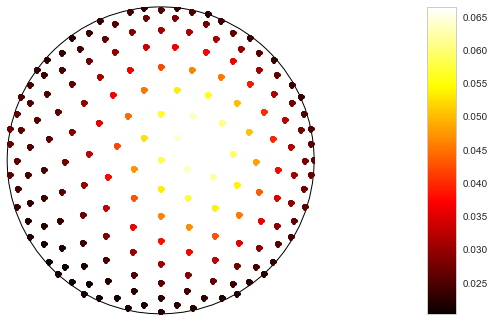

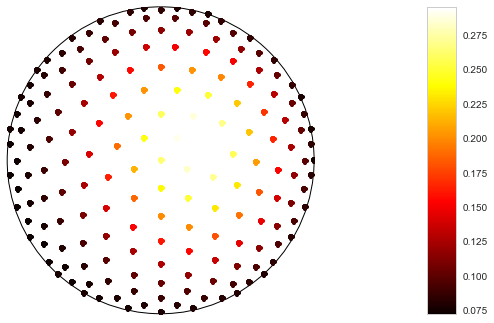

In [14]:
proj.sph_project(scmodel.sphere.vertices.T, sc_odf[idx]) 
proj.sph_project(sfmodel.sphere.vertices.T, sf_odf[idx]) 


In [15]:
np.save('sc_beta', scfit.beta)

In [16]:
np.save('sc_S0', scfit.S0)

In [17]:
np.save('sc_mean', scfit.mean_signal)